In [ ]:
import scanpy as sc
import numpy as np
from scipy.sparse import issparse


# Load annotated and raw data
adata_annot = sc.read_h5ad('annotated_all_merged.h5ad')
adata_raw   = sc.read_h5ad('raw.all_merged.h5ad')

# Align observations (cells) by barcode
# we align because AnnData uses obs_names (cell barcodes) to define the row order.
# We compute QC metrics from the raw counts but need the metadata (Donor, technology, ID's) from
# the annotated object. That requires the same cell order.
if not np.array_equal(adata_annot.obs_names, adata_raw.obs_names):
    # reorder raw to match annotated
    adata_raw = adata_raw[adata_annot.obs_names].copy()

# Copy cell metadata
# We need to do this because the raw counts file contains expression values but does not contain
# important metadata (donor, technology, condition, celltype.) We copy raw data and attach
# to annotated (.obs) metadata.
adata_raw.obs = adata_annot.obs.copy()

# IMPORTANT: copy gene metadata only if the gene sets match exactly
if np.array_equal(adata_annot.var_names, adata_raw.var_names):
    adata_raw.var = adata_annot.var.copy()
else:
    # Leave adata_raw.var unchanged; we still have gene names in adata_raw.var_names
    print(
        "Warning: the annotated and raw datasets contain different gene sets "
        f"({adata_annot.n_vars} vs {adata_raw.n_vars}).  "
        "Continuing with the raw gene metadata."
    )

# From this point *adata_raw* is the single source of truth:
# - adata_raw.X          -> raw UMI coutns
# - adata_raw.obs[..]    -> donor/technology/ID/cell type
# ----------------------------------------------------------------------
# 2. Filter to RBC‑depleted samples
#    The RBC flag is in obs["ID"] strings ("..RBCdepl.."). To be robust
# we match the substring "RBC" case-insensitive. 
# ----------------------------------------------------------------------
rbc_mask = adata_raw.obs['ID'].astype(str).str.contains('RBC', case=False)
rbc_cells = adata_raw[rbc_mask].copy()
print(f'RBC-depleted cells: {rbc_cells.n_obs}')
print(rbc_cells.obs['technology'].value_counts())

# ----------------------------------------------------------------------
# 3. Compute QC metrics from raw counts
#    • umi_counts  – total UMI counts per cell (library size)
#    • gene_counts – number of genes detected (>0 counts)
#    • mito_fraction – fraction of counts from mitochondrial genes
# Notes:
# - We protect against division by zero when computing mito_fraction
# ----------------------------------------------------------------------
def axis1_sum(mat):
    return np.asarray(mat.sum(axis=1)).ravel() if issparse(mat) else mat.sum(axis=1)

def axis1_nnz(mat):
    return np.asarray((mat > 0).sum(axis=1)).ravel() if issparse(mat) else (mat > 0).sum(axis=1)

# Total UMI counts per cell
umi_counts = axis1_sum(rbc_cells.X)
rbc_cells.obs['total_counts'] = umi_counts

# Number of detected genes per cell
gene_counts = axis1_nnz(rbc_cells.X)
rbc_cells.obs['n_genes_by_counts'] = gene_counts

# Mitochondrial fraction
mt_mask = rbc_cells.var_names.str.upper().str.startswith('MT-')
mt_counts = axis1_sum(rbc_cells.X[:, mt_mask]) if mt_mask.any() else np.zeros_like(umi_counts)
umi_safe = umi_counts.astype(float)
umi_safe[umi_safe == 0] = np.nan
rbc_cells.obs['mito_fraction'] = mt_counts / umi_safe

print(rbc_cells.obs[['total_counts','n_genes_by_counts','mito_fraction']].describe().T)


RBC-depleted cells: 139930
technology
Parse        78915
10Xfixed     45800
10X3prime    15215
Name: count, dtype: int64
                      count         mean          std   min    25%  \
total_counts       139930.0  1323.066895  2146.234131  28.0  239.0   
n_genes_by_counts  139930.0   746.442557   825.113562  20.0  207.0   
mito_fraction      139930.0     0.019042     0.038977   0.0    0.0   

                          50%          75%           max  
total_counts       544.000000  1422.000000  41090.000000  
n_genes_by_counts  420.000000   968.000000   7219.000000  
mito_fraction        0.006032     0.013072      0.263158  


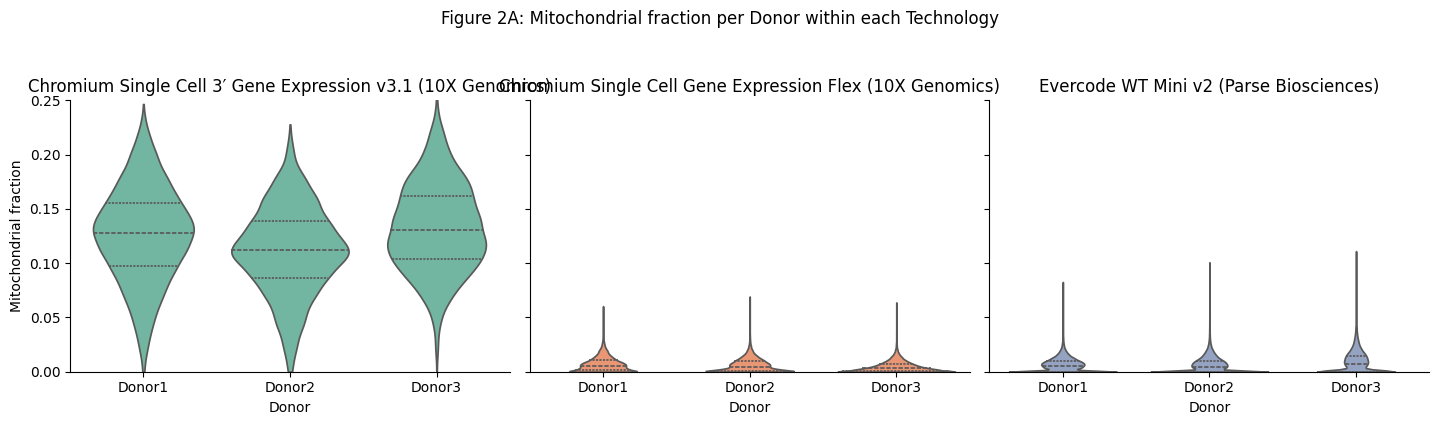

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# map variables to right columns
tech_map = {
    '10X3prime': 'Chromium Single Cell 3′ Gene Expression v3.1 (10X Genomics)',
    '10Xfixed':  'Chromium Single Cell Gene Expression Flex (10X Genomics)',
    'Parse':     'Evercode WT Mini v2 (Parse Biosciences)',
    'HIVE':      'HIVE scRNAseq v1 (Honeycomb Biotechnologies)',
}


# Prepare tidy DF
df_qc = pd.DataFrame({
    "Donor": rbc_cells.obs["Donor"].astype(str),
    "Technology_code": rbc_cells.obs["technology"].astype(str),
    "UMI counts": rbc_cells.obs["total_counts"].values,
    "Mitochondrial fraction": rbc_cells.obs["mito_fraction"].values,
})

# Order the technologies and donors
tech_order = [t for t in ["10X3prime", "10Xfixed", "Parse", "HIVE"]
              if t in df_qc["Technology_code"].unique()]

donor_order = sorted(df_qc["Donor"].unique().tolist())

# Color map (tech → color)
palette = sns.color_palette("Set2", n_colors=len(tech_order))
tech_color_map = {tech_order[i]: palette[i] for i in range(len(tech_order))}

# Faceted violin plot: one column per technology
g = sns.catplot(
    data=df_qc,
    kind="violin",
    col="Technology_code",
    x="Donor",
    y="Mitochondrial fraction",
    order=donor_order,
    col_order=tech_order,
    hue="Technology_code",
    palette=tech_color_map,
    inner="quartile",
    cut=0,
    sharey=True,
    height=4,
    aspect=1.1
)

# y-range to match the paper
g.set(ylim=(0, 0.25))

# Replace top titles with full descriptive labels
for ax, tech in zip(g.axes.flatten(), tech_order):
    ax.set_title(tech_map.get(tech, tech))

# Clean x-axis
g.set_xlabels("Donor")
g.set_ylabels("Mitochondrial fraction")

# Remove the legend (color is redundant per panel)
g._legend.remove()

plt.suptitle("Figure 2A: Mitochondrial fraction per Donor within each Technology", y=1.05)
plt.tight_layout()
plt.show()


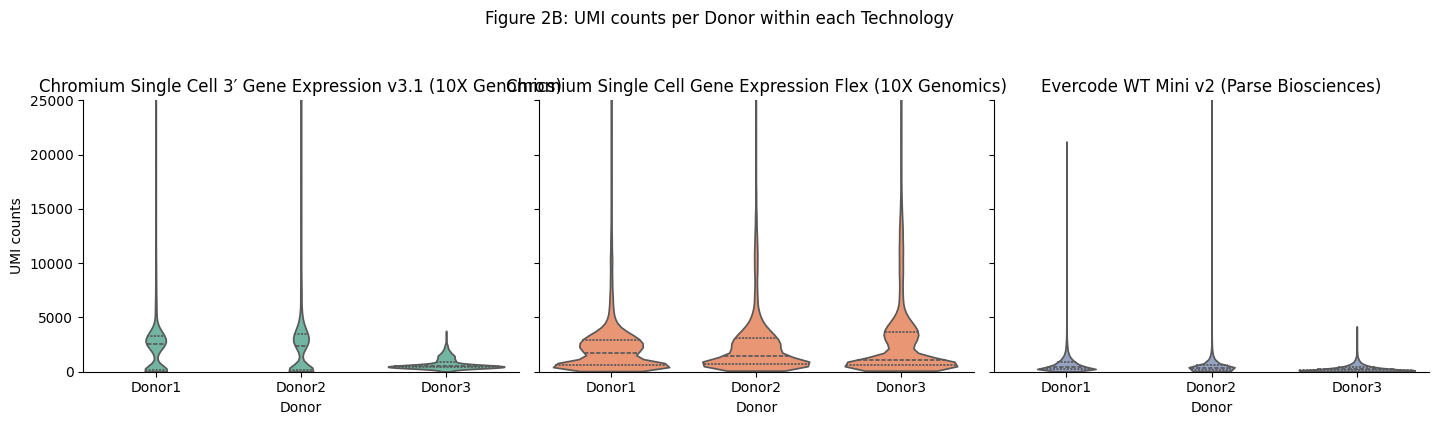

In [3]:
g = sns.catplot(
    data=df_qc,
    kind="violin",
    col="Technology_code",
    x="Donor",
    y="UMI counts",
    order=donor_order,
    col_order=tech_order,
    hue="Technology_code",
    palette=tech_color_map,
    inner="quartile",
    cut=0,
    sharey=True,
    height=4,
    aspect=1.1
)

g.set(ylim=(0, 25000))

# Replace top titles
for ax, tech in zip(g.axes.flatten(), tech_order):
    ax.set_title(tech_map.get(tech, tech))

g.set_xlabels("Donor")
g.set_ylabels("UMI counts")

# Remove legend — redundant because each panel is a single tech
g._legend.remove()

plt.suptitle("Figure 2B: UMI counts per Donor within each Technology", y=1.05)
plt.tight_layout()
plt.show()


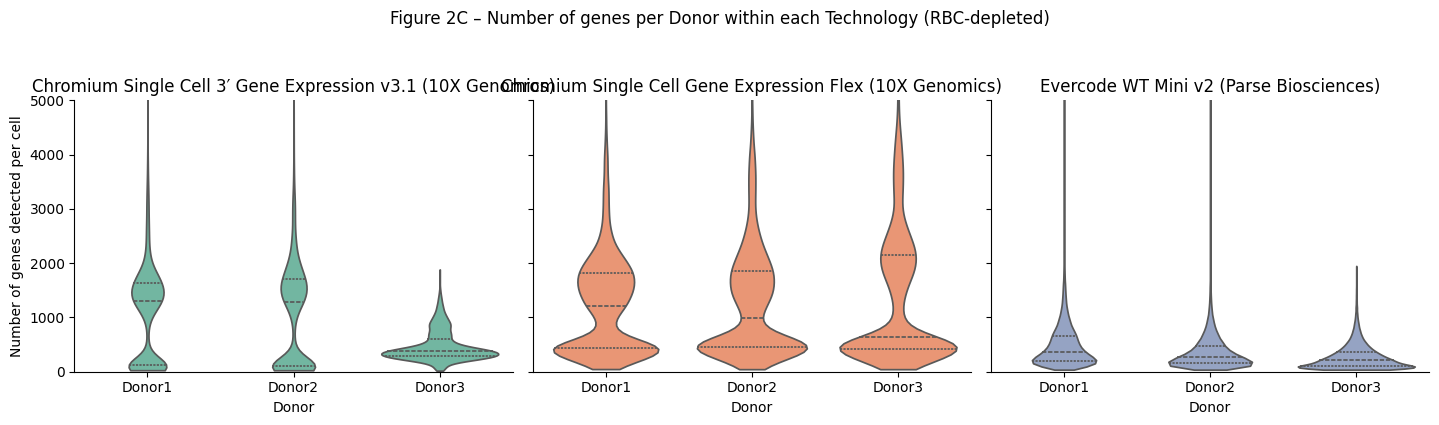

In [4]:
# =============================================================================
# Figure 2C — “Number of genes” per Donor × Technology (RBC-depleted cells)
# =============================================================================
# Goal:
#   • Reproduce Figure 2C from the paper, using the *n_genes_by_counts*
#     QC metric as the y-axis.
#   • Each panel (column) represents a Technology (10X 3′, 10X Flex, Parse, HIVE).
#   • Within each technology, the x-axis shows Donor 1–3 side by side.
#   • Violin colors correspond to technology; all violins share the same y-range.
#
# Inputs:
#   rbc_cells.obs['Donor']               – donor/sample ID per cell
#   rbc_cells.obs['technology']          – short technology codes (10X3prime, 10Xfixed, Parse, HIVE)
#   rbc_cells.obs['n_genes_by_counts']   – number of detected genes per cell
#
# Expected output:
#   A multi-panel figure (one column per technology), each showing three violins
#   (Donor 1–3) colored by technology, y-axis from 0 → 5000.

# -------------------------------------------------------------------------
# 1) Build a tidy DataFrame for plotting
# -------------------------------------------------------------------------
df_qc_genes = pd.DataFrame({
    "Donor": rbc_cells.obs["Donor"].astype(str),
    "Technology_code": rbc_cells.obs["technology"].astype(str),
    "Number of genes": rbc_cells.obs["n_genes_by_counts"].astype(float),
})

# Order technologies (only those present in the current dataset)
tech_order = [t for t in ["10X3prime", "10Xfixed", "Parse", "HIVE"]
              if t in df_qc_genes["Technology_code"].unique()]

# Order donors alphabetically/numerically for consistent x-axis placement
donor_order = sorted(df_qc_genes["Donor"].unique().tolist())

# -------------------------------------------------------------------------
# 2) Define color palette (consistent with earlier figures)
# -------------------------------------------------------------------------
# We assign one distinct color per technology for visual consistency
base_palette = sns.color_palette("Set2", n_colors=4)
tech_color_map = {code: base_palette[i] for i, code in enumerate(["10X3prime", "10Xfixed", "Parse", "HIVE"])}
palette_list = [tech_color_map[c] for c in tech_order]

# -------------------------------------------------------------------------
# 3) Plot — one panel per technology, violins grouped by donor
# -------------------------------------------------------------------------
g = sns.catplot(
    data=df_qc_genes,
    kind="violin",
    col="Technology_code",        # → each column = one technology
    x="Donor",                    # → donors on x-axis within each technology
    y="Number of genes",          # → QC metric on y-axis
    order=donor_order,            # consistent donor order
    col_order=tech_order,         # consistent tech order (left→right)
    hue="Technology_code",        # color violins by technology
    palette=tech_color_map,       # fixed color map (ensures consistency)
    inner="quartile",             # show median + quartile lines inside violins
    cut=0,                        # don't extend violins beyond data range
    sharey=True,                  # same y-axis scale across panels
    height=4,                     # panel height (in inches)
    aspect=1.1                    # width/height ratio
)

# -------------------------------------------------------------------------
# 4) Styling / axes / titles
# -------------------------------------------------------------------------
# Set a consistent y-axis range to match the paper
g.set(ylim=(0, 5000))

# Replace the short technology codes in the titles with descriptive names
tech_map = {
    "10X3prime": "Chromium Single Cell 3′ Gene Expression v3.1 (10X Genomics)",
    "10Xfixed":  "Chromium Single Cell Gene Expression Flex (10X Genomics)",
    "Parse":     "Evercode WT Mini v2 (Parse Biosciences)",
    "HIVE":      "HIVE scRNAseq v1 (Honeycomb Biotechnologies)",
}
for ax, tech in zip(g.axes.flatten(), tech_order):
    ax.set_title(tech_map.get(tech, tech))

# Label axes cleanly
g.set_xlabels("Donor")
g.set_ylabels("Number of genes detected per cell")

# Remove legend (redundant, color = panel)
if g._legend is not None:
    g._legend.remove()

# Global figure title and layout
plt.suptitle("Figure 2C – Number of genes per Donor within each Technology (RBC-depleted)", y=1.05)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 5) Sanity checks / interpretation
# -------------------------------------------------------------------------
# • Each technology panel shows 3 violins (Donor 1–3).
# • The y-axis range (0–5000) highlights that typical single-cell libraries
#   detect hundreds to a few thousand genes per cell.
# • Expect Parse and 10X Flex to cluster near 1–3 k genes; 10X 3′ may extend higher.
# • If a panel is missing → that technology had no RBC-depleted cells in your dataset.


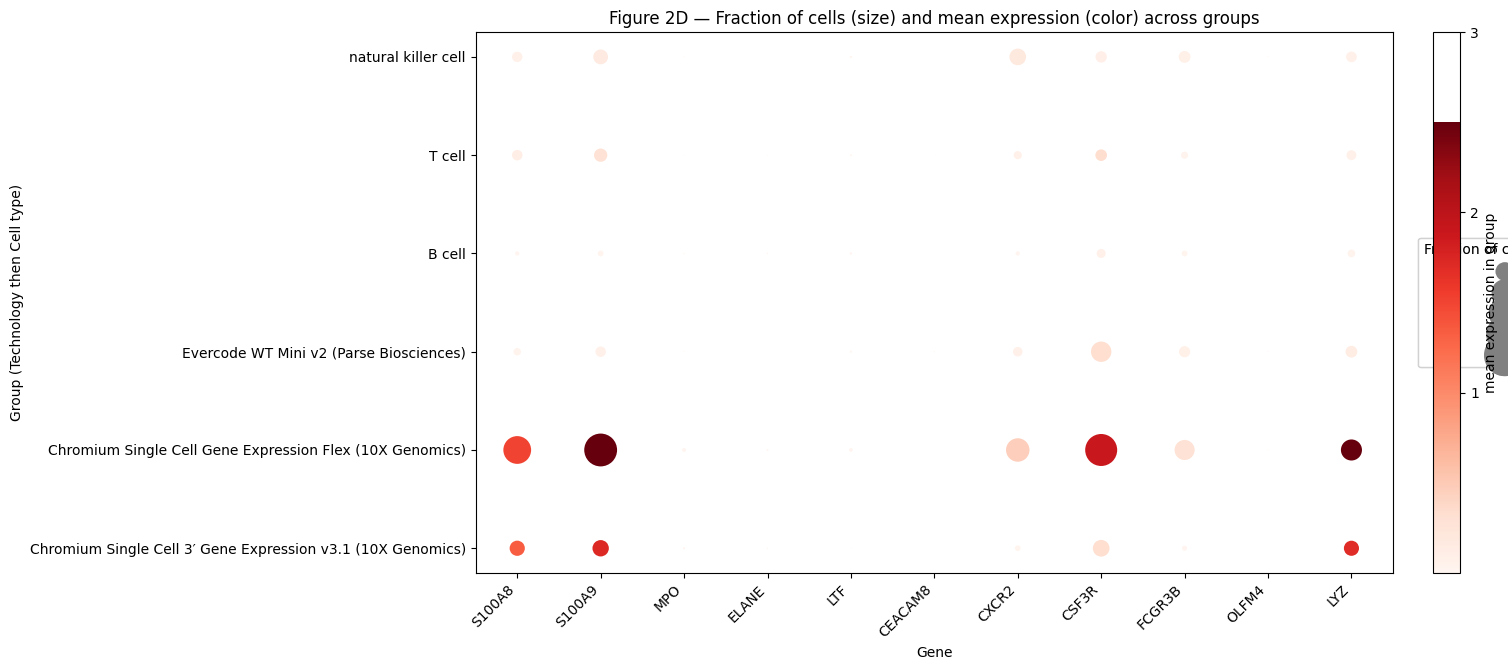

In [7]:
# =============================================================================
# Figure 2D (extended) — Dot plot across Technologies *and* Cell Types
# =============================================================================
# Goal:
#   • Rows = first each Technology, then key immune Cell Types (B/T/Mono/NK/Neutrophil).
#   • Columns = selected genes (stable markers).
#   • Dot size  = fraction of cells in the group expressing the gene (>0 counts).
#   • Dot color = log1p(mean raw expression) in the group (white→dark red).
#
# Inputs (from previous steps):
#   rbc_cells: AnnData with raw counts in .X and metadata in .obs
#   rbc_cells.obs['technology']: technology code ('10X3prime','10Xfixed','Parse','HIVE')
#   rbc_cells.obs['celltype*'] : cell type labels (we'll auto-pick a suitable column)
#   rbc_cells.var_names: gene symbols
#
# Output:
#   A composite dot plot with Technologies on top followed by selected Cell Types;
#   right side shows a size legend for fraction (%) and a colorbar for mean expression.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import issparse

# -----------------------------
# 1) Configure genes & columns
# -----------------------------
genes_for_dotplot = [
    "S100A8", "S100A9", "MPO", "ELANE", "LTF", "CEACAM8", "CXCR2",
    "CSF3R", "FCGR3B", "OLFM4", "LYZ", "GAPDH"
]
present_genes = [g for g in genes_for_dotplot if g in rbc_cells.var_names]
if not present_genes:
    raise ValueError("None of the selected genes are present in rbc_cells.var_names.")

# Pick a suitable cell-type column
celltype_candidates = ["celltype1", "celltype0", "celltype2", "cell_type", "CellType"]
celltype_col = next((c for c in celltype_candidates if c in rbc_cells.obs.columns), None)
if celltype_col is None:
    raise KeyError("Could not find a cell-type column in rbc_cells.obs.")

# Cell types to include (in the paper’s order)
wanted_celltypes = ["B cell", "T cell", "monocyte", "natural killer cell", "neutrophil"]

# Technologies (order for rows)
tech_codes = rbc_cells.obs["technology"].astype(str).unique().tolist()
tech_order = [t for t in ["10X3prime", "10Xfixed", "Parse", "HIVE"] if t in tech_codes]

# Pretty mapping for technology labels (used in y-tick text)
tech_map = {
    "10X3prime": "Chromium Single Cell 3′ Gene Expression v3.1 (10X Genomics)",
    "10Xfixed":  "Chromium Single Cell Gene Expression Flex (10X Genomics)",
    "Parse":     "Evercode WT Mini v2 (Parse Biosciences)",
    "HIVE":      "HIVE scRNAseq v1 (Honeycomb Biotechnologies)",
}

# Helper: dense view
def to_dense(m):
    return m.toarray() if issparse(m) else np.asarray(m)

# ---------------------------------------------
# 2) Aggregate per-group (tech and cell type)
# ---------------------------------------------
rows = []

# Per-technology
for tech in tech_order:
    sub = rbc_cells[rbc_cells.obs["technology"].astype(str) == tech]
    X = to_dense(sub[:, present_genes].X)
    frac = (X > 0).mean(axis=0)        # fraction expressing
    mean_expr = X.mean(axis=0)         # mean raw counts
    for g, f, m in zip(present_genes, frac, mean_expr):
        rows.append({
            "Group": tech,             # keep as the code; map later for y-axis text
            "GroupType": "Technology",
            "Gene": g,
            "Fraction": f,
            "MeanExpr": np.log1p(m)    # log1p scaling for color
        })

# Per-cell-type (across ALL technologies)
present_ct = [ct for ct in wanted_celltypes if ct in set(rbc_cells.obs[celltype_col].astype(str))]
for ct in present_ct:
    sub = rbc_cells[rbc_cells.obs[celltype_col].astype(str) == ct]
    X = to_dense(sub[:, present_genes].X)
    frac = (X > 0).mean(axis=0)
    mean_expr = X.mean(axis=0)
    for g, f, m in zip(present_genes, frac, mean_expr):
        rows.append({
            "Group": ct,               # exact cell type string; no mapping
            "GroupType": "CellType",
            "Gene": g,
            "Fraction": f,
            "MeanExpr": np.log1p(m)
        })

dot_df = pd.DataFrame(rows)

# ---------------------------------------------
# 3) Build y-axis order: techs, then cell types
# ---------------------------------------------
y_order = tech_order + present_ct
# Map tech codes → descriptive labels for y-ticks; keep cell-type names as-is
def pretty_group_label(x):
    return tech_map.get(x, x)

# Ensure categorical ordering
dot_df["Group"] = pd.Categorical(dot_df["Group"], categories=y_order, ordered=True)
dot_df["Gene"] = pd.Categorical(dot_df["Gene"], categories=present_genes, ordered=True)

# ---------------------------------------------
# 4) Scatter plot: size=fraction, color=log1p(mean)
# ---------------------------------------------
fig_h = 0.8 * len(y_order) + 2
fig_w = 1.1 * len(present_genes) + 3
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Coordinates on grid
x_pos = {g: i for i, g in enumerate(present_genes)}
y_pos = {grp: i for i, grp in enumerate(y_order)}

xs = dot_df["Gene"].map(x_pos).values
ys = dot_df["Group"].map(y_pos).values

# Fraction → size (% legend will show 20–100)
sizes = (dot_df["Fraction"].values * 100.0)  # as percent
size_scale = 9.0  # visual multiplier (tweak if dots look too small/large)
sizes_pts = (sizes * size_scale)            # points^2 for scatter

# Color = log1p(mean expression); use white→dark red
colors = dot_df["MeanExpr"].values
sc = ax.scatter(xs, ys, s=sizes_pts, c=colors, cmap="Reds", edgecolor="none")

# Axes
ax.set_xticks(range(len(present_genes)))
ax.set_xticklabels(present_genes, rotation=45, ha="right")
ax.set_yticks(range(len(y_order)))
ax.set_yticklabels([pretty_group_label(y) for y in y_order])

ax.set_xlabel("Gene")
ax.set_ylabel("Group (Technology then Cell type)")
ax.set_title("Figure 2D — Fraction of cells (size) and mean expression (color) across groups")

# ---------------------------------------------
# 5) Legends on the right
# ---------------------------------------------
# (A) Size legend: Fraction (%) = 20, 40, 60, 80, 100
legend_percents = [20, 40, 60, 80, 100]
legend_sizes = [p * size_scale for p in legend_percents]

# Dummy handles for size legend
handles = [plt.scatter([], [], s=s, color="gray", edgecolor="none") for s in legend_sizes]
labels = [f"{p}" for p in legend_percents]

size_legend = ax.legend(
    handles, labels,
    title="Fraction of cells in group (%)",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)
ax.add_artist(size_legend)

# (B) Colorbar: mean expression in group (log1p scale with ticks 1,2,3)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean expression in group")
cbar.set_ticks([1, 2, 3])
cbar.set_ticklabels(["1", "2", "3"])

plt.tight_layout()
plt.show()

# ---------------------------------------------
# 6) Notes
# ---------------------------------------------
# • Rows list all technologies first (pretty mapped names), then five immune cell types.
# • Dot size legend shows fraction (%) with reference sizes at 20/40/60/80/100.
# • Colorbar uses log1p(mean) but is *labeled* with 1/2/3 for easy reading.
# • If a row is missing, that group had no RBC-depleted cells (or cell type not present).
# • Adjust `size_scale` if dots look too large/small for your monitor or export size.


C:\Users\lazar\AppData\Local\Temp\ipykernel_36272\3923315232.py:25: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if 'X_umap' not in adata_annot.obsm_keys():


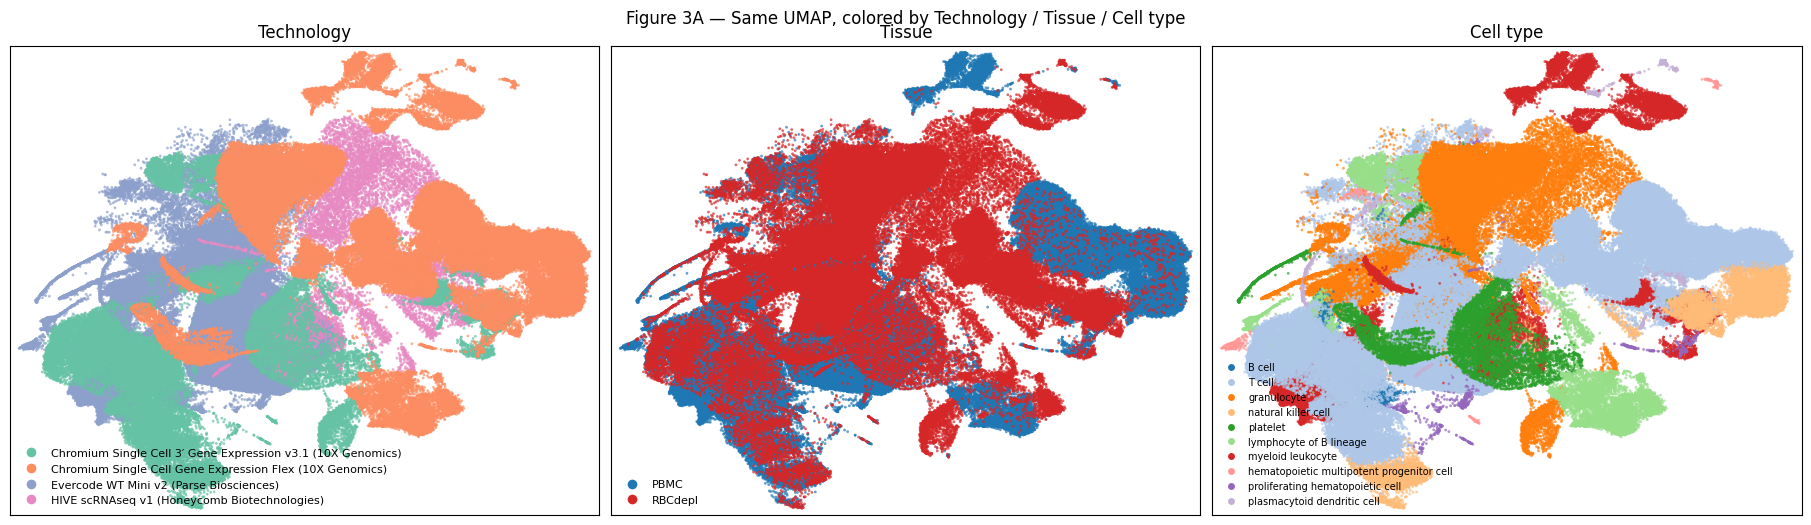

In [8]:
# =============================================================================
# Figure 3A — Same UMAP embedding, colored by Technology / Tissue / Cell type
# =============================================================================
# Inputs:
#   adata_annot: annotated AnnData with metadata in .obs and UMAP in .obsm['X_umap']
# Required .obs columns:
#   - 'technology' (codes like 10X3prime, 10Xfixed, Parse, HIVE)
#   - 'tissue' (PBMC; RBC-depleted may be embedded in 'ID' field)
#   - one of ['celltype1','celltype0','celltype2','dblabel'] for cell identity
#
# Output:
#   Three panels with identical UMAP shapes:
#     Left:  colored by technology
#     Middle: colored by tissue (PBMC vs RBCdepl)
#     Right: colored by cell type

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) Build a plotting DataFrame
# ----------------------------
if 'X_umap' not in adata_annot.obsm_keys():
    raise KeyError("UMAP coordinates not found in adata_annot.obsm['X_umap'].")

umap = adata_annot.obsm['X_umap']
df = pd.DataFrame({
    'UMAP1': umap[:, 0],
    'UMAP2': umap[:, 1],
})

# Technology codes (required)
if 'technology' not in adata_annot.obs.columns:
    raise KeyError("Expected 'technology' in adata_annot.obs.")
df['technology'] = adata_annot.obs['technology'].astype(str).values

# Tissue:
# - Use 'tissue' if present (often "PBMC")
# - Add "RBCdepl" based on 'ID' substring (case-insensitive)
tissue_series = None
if 'tissue' in adata_annot.obs.columns:
    tissue_series = adata_annot.obs['tissue'].astype(str)
else:
    tissue_series = pd.Series(['Unknown'] * adata_annot.n_obs, index=adata_annot.obs_names)

if 'ID' in adata_annot.obs.columns:
    id_str = adata_annot.obs['ID'].astype(str)
    is_rbc = id_str.str.contains('RBC', case=False, na=False)
    # Prefer explicit RBCdepl over generic tissue label
    tissue_series = np.where(is_rbc, 'RBCdepl', tissue_series)

df['tissue'] = pd.Series(tissue_series, index=adata_annot.obs_names).astype(str).values

# Cell type column: pick the best available
celltype_candidates = ['celltype1','celltype0','celltype2','dblabel']
celltype_col = next((c for c in celltype_candidates if c in adata_annot.obs.columns), None)
if celltype_col is None:
    raise KeyError("No cell type column found (looked for 'celltype1','celltype0','celltype2','dblabel').")

df['celltype'] = adata_annot.obs[celltype_col].astype(str).values

# ---------------------------------------
# 2) Category orders and nice label maps
# ---------------------------------------
tech_order = [t for t in ['10X3prime','10Xfixed','Parse','HIVE'] if t in df['technology'].unique()]
tech_map = {
    '10X3prime': "Chromium Single Cell 3′ Gene Expression v3.1 (10X Genomics)",
    '10Xfixed':  "Chromium Single Cell Gene Expression Flex (10X Genomics)",
    'Parse':     "Evercode WT Mini v2 (Parse Biosciences)",
    'HIVE':      "HIVE scRNAseq v1 (Honeycomb Biotechnologies)",
}
tech_palette = sns.color_palette('Set2', n_colors=max(1, len(tech_order)))
tech_color_map = {code: tech_palette[i] for i, code in enumerate(tech_order)}

# Tissue order & colors (PBMC vs RBCdepl)
tissue_order = [t for t in ['PBMC','RBCdepl'] if t in df['tissue'].unique()]
# Fallback: keep whatever is there, but ensure deterministic order
if not tissue_order:
    tissue_order = sorted(df['tissue'].unique().tolist())

tissue_color_map = {
    'PBMC':    '#1f77b4',  # blue
    'RBCdepl': '#d62728',  # red
}
# Fill any unknowns with gray
for t in df['tissue'].unique():
    tissue_color_map.setdefault(t, '#7f7f7f')

# Cell type order: put common immune types first if present
preferred_celltypes = [
    'B cell', 'T cell', 'Natural killer cell', 'monocyte',
    'neutrophil', 'granulocyte', 'Hematopoietic multipotent progenitor cell'
]
present_celltypes = df['celltype'].unique().tolist()
celltype_order = [c for c in preferred_celltypes if c in present_celltypes]
celltype_order += [c for c in present_celltypes if c not in celltype_order]  # append the rest

# Distinct palette for cell types (extend as needed)
celltype_colors = sns.color_palette('tab20', n_colors=len(celltype_order))
celltype_color_map = {c: celltype_colors[i] for i, c in enumerate(celltype_order)}

# ---------------------------------------
# 3) Plot — three panels, same axes limits
# ---------------------------------------
# Compute shared limits so shapes are identical
xlim = (df['UMAP1'].min() - 0.5, df['UMAP1'].max() + 0.5)
ylim = (df['UMAP2'].min() - 0.5, df['UMAP2'].max() + 0.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Panel 1: Technology
ax = axes[0]
# map colors for each point
colors_tech = df['technology'].map(lambda t: tech_color_map.get(t, '#7f7f7f'))
ax.scatter(df['UMAP1'], df['UMAP2'], c=colors_tech, s=4, alpha=0.7, linewidths=0)
ax.set_title('Technology')
ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.set_xticks([]); ax.set_yticks([])
# Legend (compact)
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=tech_color_map[c], markersize=8, label=tech_map.get(c,c))
           for c in tech_order]
ax.legend(handles=handles, title='', loc='lower left', fontsize=8, frameon=False)

# Panel 2: Tissue (PBMC vs RBCdepl)
ax = axes[1]
colors_tissue = df['tissue'].map(lambda t: tissue_color_map.get(t, '#7f7f7f'))
ax.scatter(df['UMAP1'], df['UMAP2'], c=colors_tissue, s=4, alpha=0.7, linewidths=0)
ax.set_title('Tissue')
ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.set_xticks([]); ax.set_yticks([])
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=tissue_color_map[c], markersize=8, label=c)
           for c in tissue_order]
ax.legend(handles=handles, title='', loc='lower left', fontsize=8, frameon=False)

# Panel 3: Cell type
ax = axes[2]
colors_cell = df['celltype'].map(lambda c: celltype_color_map.get(c, '#7f7f7f'))
ax.scatter(df['UMAP1'], df['UMAP2'], c=colors_cell, s=4, alpha=0.7, linewidths=0)
ax.set_title('Cell type')
ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.set_xticks([]); ax.set_yticks([])
# Put a scrollable-feel legend (may be long)
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=celltype_color_map[c], markersize=6, label=c)
           for c in celltype_order[:15]]  # show top ~15 to avoid clutter; adjust as needed
ax.legend(handles=handles, title='', loc='lower left', fontsize=7, frameon=False)

plt.suptitle('Figure 3A — Same UMAP, colored by Technology / Tissue / Cell type', y=1.02)
plt.show()
